# **<a id="Content">HnM RecSys Notebook 9417</a>**

## **<a id="Content">Table of Contents</a>**
* [**<span>1. Imports</span>**](#Imports)  
* [**<span>2. Helper Functions/Decorators</span>**](#Helper-Functions)
* [**<span>5. LightGBM Model</span>**](#LightGBM-Model) 

## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import re
import warnings
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

## Helper-Functions

In [16]:
from datetime import datetime, timedelta

# only use last x weeks of transactions data since data is too large
def filter_transactions_last_x_weeks(transactions, x = 10):
    # Convert date strings to datetime objects
    transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

    # Calculate the date x weeks ago from the latest transaction date
    latest_date = transactions['t_dat'].max()
    cutoff_date = latest_date - timedelta(weeks=x)

    # Filter transactions to only include those in the last x weeks
    filtered_transactions = transactions.loc[transactions['t_dat'] >= cutoff_date].copy()

    return filtered_transactions

In [17]:
def filter_customers_and_articles(customers, articles, filtered_transactions):
    # Get unique customer and article IDs from filtered transactions
    customer_ids = filtered_transactions['customer_id'].unique()
    article_ids = filtered_transactions['article_id'].unique()

    # Filter customers and articles to only include those in filtered transactions
    customers_filtered = customers.loc[customers['customer_id'].isin(customer_ids)].copy()
    articles_filtered = articles.loc[articles['article_id'].isin(article_ids)].copy()

    return customers_filtered, articles_filtered

## LightGBM

A comparison of the top GBDT models today. LightGBM is the fastest to train.

|Feature|LightGBM|XGBoost|CatBoost|
|:----|:----|:----|:----|
|Categoricals|Supports categorical features via one-hot encoding|Supports categorical features via one-hot encoding|Automatically handles categorical features using embeddings|
|Speed|Very fast training and prediction|Fast training and prediction|Slower than LightGBM and XGBoost|
|Handling Bias|Handles unbalanced classes via 'is_unbalance'|Handles unbalanced classes via 'scale_pos_weight'|Automatically handles unbalanced classes|
|Handling NaNs|Handles NaN values natively|Requires manual handling of NaNs|Automatically handles NaN values using special category|
|Custom Loss|Supports custom loss functions|Supports custom loss functions|Supports custom loss functions|


To use LightGBM for a ranking problem, we treat this as a binary classification problem where the target variable is whether an item is relevant or not to the user.

Alternatively, we can use LightGBM's ranking API, which is designed for ranking problems. Instead of optimizing for accuracy, the ranking API optimizes for ranking metric MAP (MAP support deprecated however). 

### Feature Engineering

In [18]:
# LightGBM imports

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [19]:
import pickle

# open user_item_matrix_200
with open('user_item_matrix_200.pkl', 'rb') as f:
    user_item_matrix = pickle.load(f)

# open customer and articels incides map
with open('lightgbm/customer_id_indices_map.pkl', 'rb') as f:
    customer_id_indices_map = pickle.load(f)

with open('lightgbm/article_id_indices_map.pkl', 'rb') as f:
    article_id_indices_map = pickle.load(f)

# load df from pickle file for time-based split
with open('lightgbm/df.pkl', 'rb') as f:
    df = pickle.load(f)

# load final_df from pickle file for clean processing
with open('lightgbm/df_pos_neg.pkl', 'rb') as f:
    final_df = pickle.load(f)

In [20]:
final_df.columns

Index(['t_dat', 'price', 'sales_channel_1', 'sales_channel_2', 'quantity',
       'article_engagement_ratio', 'user_index', 'item_index', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'time_diff_days',
       'user_purchase_quant', 'RFM_Score', 'product_type_no',
       'graphical_appearance_no', 'department_no', 'index_code', 'section_no',
       'age_diff', 'mean_purchase_age', 'max_purchase_age', 'min_purchase_age',
       'article_preference', 'item_purchase_frequency', 'item_avg_price_level',
       'target', 'year', 'month', 'day', 'garment_group_no_1001',
       'garment_group_no_1002', 'garment_group_no_1003',
       'garment_group_no_1005', 'garment_group_no_1006',
       'garment_group_no_1007', 'garment_group_no_1008',
       'garment_group_no_1009', 'garment_group_no_1010',
       'garment_group_no_1011', 'garment_group_no_1012',
       'garment_group_no_1013', 'garment_group_no_1014',
       'garment_group_no_1016', 'garment_group_no_1017',


### Model Training

In [21]:
# target encoding
# from category_encoders import TargetEncoder
# from sklearn.model_selection import KFold

# # Define columns to target encode
# cols_to_encode = ['department_no', 'product_type_no', 'section_no', 'graphical_appearance_no']

# # Define number of folds for cross-validation
# n_splits = 5

# # Create KFold object for cross-validation
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Perform target encoding with cross-validation
# for col in cols_to_encode:
#     final_df[f'{col}_te'] = 0
#     te = TargetEncoder(cols=[col])
#     for train_idx, val_idx in kf.split(final_df):
#         te.fit(final_df.iloc[train_idx][[col]], final_df.iloc[train_idx]['target'])
#         final_df.loc[val_idx, f'{col}_te'] = te.transform(final_df.iloc[val_idx][[col]]).values.flatten()

In [22]:
# ---- memory optimizations -------------

# reference: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

# iterate through all the columns of a dataframe and reduce the int and float data types to the smallest possible size, ex. customer_id should not be reduced from int64 to a samller value as it would have collisions
import numpy as np
import pandas as pd

def reduce_mem_usage(df):
    """Iterate over all the columns of a DataFrame and modify the data type
    to reduce memory usage, handling ordered Categoricals"""
    
    # check the memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'category':
            if df[col].cat.ordered:
                # Convert ordered Categorical to an integer
                df[col] = df[col].cat.codes.astype('int16')
            else:
                # Convert unordered Categorical to a string
                df[col] = df[col].astype('str')
        
        elif col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    # check the memory usage after optimization
    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))

    # calculate the percentage of the memory usage reduction
    mem_reduction = 100 * (start_mem - end_mem) / start_mem
    print("Memory usage decreased by {:.1f}%".format(mem_reduction))
    
    return df

In [23]:
# refrence: https://github.com/zhouyonglong/ml_metrics/blob/master/Python/ml_metrics/average_precision.py

from sklearn.metrics import make_scorer

def mapk(y_true, y_pred, k=12):
    """
    Computes the mean average precision at k.
    """
    return np.mean([apk(a, p, k) for a, p in zip(y_true, y_pred)])

def apk(actual, predicted, k=12):
    """
    Computes the average precision at k.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

In [24]:
def time_based_train_test_split(final_df, test_size=0.2):

    # Sort dataframe by date in ascending order
    final_df = final_df.sort_values(by='t_dat')

    # Calculate cutoff index
    cutoff_index = int(len(final_df) * (1-test_size))

    # Create train and test dataframes
    train_df = final_df[:cutoff_index]
    test_df = final_df[cutoff_index:]

    # Drop date column from train and test dataframes
    train_df = train_df.drop('t_dat', axis=1)
    test_df = test_df.drop('t_dat', axis=1)

    # split train_df into X_train and y_train
    X_train = train_df.drop('target', axis=1)
    y_train = train_df['target']

    # split test_df into X_test and y_test
    X_test = test_df.drop('target', axis=1)
    y_test = test_df['target']

    return X_train, X_test, y_train, y_test

In [25]:
# 80/20 time-based split to curb data leakage
# X_train, X_test, y_train, y_test = time_based_train_test_split(final_df, test_size=0.2)
# final_df_top_50 = final_df_top_50.drop('date', axis=1)
from sklearn.model_selection import train_test_split
final_df = final_df.drop('index_code', axis=1)
final_df = final_df.drop(['day', 'month', 'year'], axis=1)
# drop the sales_chanel_id columns since they're not useful (from eda)
final_df = final_df.drop('sales_channel_1', axis=1)
final_df = final_df.drop('sales_channel_2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(final_df.drop(['target'], axis=1), final_df['target'], test_size=0.2, random_state=42, stratify=final_df['target'])

# drop the date column from X_train, X_test
X_train = X_train.drop('t_dat', axis=1)
X_test = X_test.drop('t_dat', axis=1)

# redcue memory usage
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# print the shape of X_train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Memory usage of dataframe is 19.67 MB
Memory usage after optimization is: 13.45 MB
Memory usage decreased by 31.6%
Memory usage of dataframe is 4.92 MB
Memory usage after optimization is: 3.36 MB
Memory usage decreased by 31.6%
(133057, 50)
(33265, 50)
(133057,)
(33265,)


In [26]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.feature_selection import RFECV
import joblib
from sklearn.metrics import get_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [27]:
# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV

# # define the parameter grid
# param_grid = {
#     'n_estimators': [500, 1000, 2000],
#     'num_leaves': [32, 64, 128],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'lambda_l1': [0.0, 0.1, 0.5],
#     'lambda_l2': [0.0, 0.1, 0.5]
# }

# # define the classifier
# classifier = lgb.LGBMClassifier(objective='binary', boosting_type='dart', importance_type='gain', verbose=10)

# # define the GridSearchCV object
# grid_search = GridSearchCV(
#     estimator=classifier,
#     param_grid=param_grid,
#     scoring='roc_auc',  # use AUC as the scoring metric
#     cv=5,  # use 5-fold cross-validation
#     n_jobs=-1,  # use all available cores
#     verbose=10
# )

# # fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # print the best hyperparameters and the corresponding AUC score
# print(f"Best hyperparameters: {grid_search.best_params_}")
# print(f"Best AUC score: {grid_search.best_score_}")

In [28]:
# Extract the best model from the grid search
# best_model = grid_search.best_estimator_

# # Evaluate the best model on the training set
# y_train_pred = best_model.predict_proba(X_train)[:, 1]
# train_auc = roc_auc_score(y_train, y_train_pred)
# print(f"Training AUC: {train_auc:.4f}")

# # Evaluate the best model on the test set
# y_test_pred = best_model.predict_proba(X_test)[:, 1]
# test_auc = roc_auc_score(y_test, y_test_pred)
# print(f"Test AUC: {test_auc:.4f}")

In [44]:
classifier = lgb.LGBMClassifier(
    objective="binary",
    metric="auc",
    boosting_type="dart",
    n_estimators=1000, # increase the number of trees
    importance_type='gain', # normalized gain to compare different models
    verbose=10, 
    lambda_l2=0.5,
    learning_rate=0.01, # learning rate
)

# train and evaluate using auc
classifier.fit(X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    early_stopping_rounds=50,
    verbose=10
)

C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Number of positive: 101297, number of negative: 31760
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.053204
[LightGBM] [Debug] init for col-wise cost 0.000005 seconds, init for row-wise cost 0.005645 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 133057, number of used features: 48
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.761305 -> initscore=1.159849
[LightGBM] [Info] Start training from score 1.159849
[LightGBM] [De

C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[50]	valid_0's auc: 0.903519
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMClassifier(boosting_type='dart', importance_type='gain', lambda_l2=0.5,
               learning_rate=0.01, metric='auc', n_estimators=1000,
               objective='binary', verbose=10)

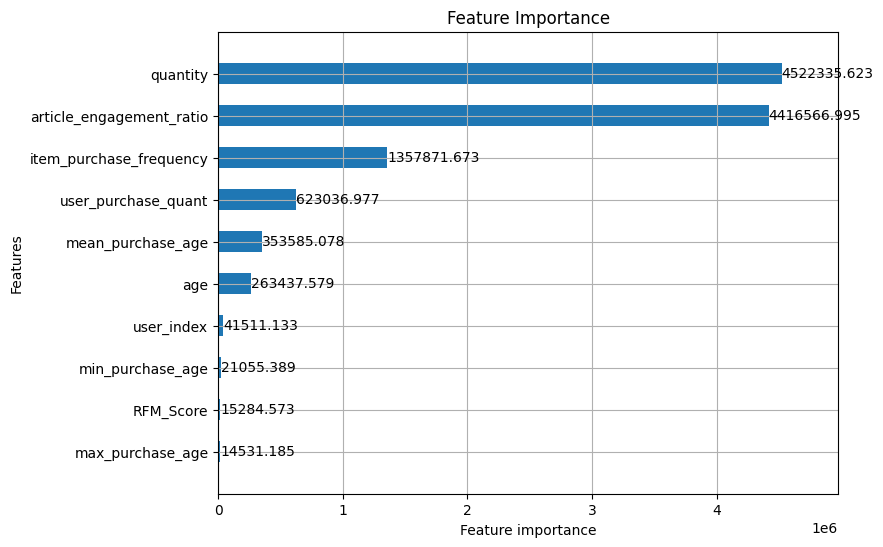

In [45]:
# Plot feature importance scores
fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_importance(classifier, max_num_features=10, height=0.5, ax=ax)
plt.title('Feature Importance')
plt.show()

In [31]:
# maximize map@12 using dart boosting
ranker = lgb.LGBMRanker(
    objective="lambdarank",
    metric="map",
    eval_at=12,
    boosting_type="dart",
    n_estimators=20, # decrease the number of trees
    importance_type='gain', # normalized gain to compare different models
    verbose=1, 
    learning_rate=0.005, # decrease the learning rate
    lambda_l2 = 0.5
)

In [32]:
# train and eval usin map@12
train_baskets = X_train.groupby(['user_index'])['item_index'].count().values
test_baskets = X_test.groupby(['user_index'])['item_index'].count().values

ranker = ranker.fit(X_train, y_train,
    group=train_baskets,
    eval_set=[(X_test, y_test)],
    eval_group=[test_baskets],
    eval_metric='map',
    eval_at=12,
    verbose=1
)

C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\sklearn.py:621: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Total groups: 200, total data: 133057
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 133057, number of used features: 48
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Total groups: 200, total data: 33265
[1]	valid_0's map@12: 0.973568
[2]	valid_0's map@12: 0.986951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@12: 0.987352
[LightGBM] [Warning] No further splits with positive

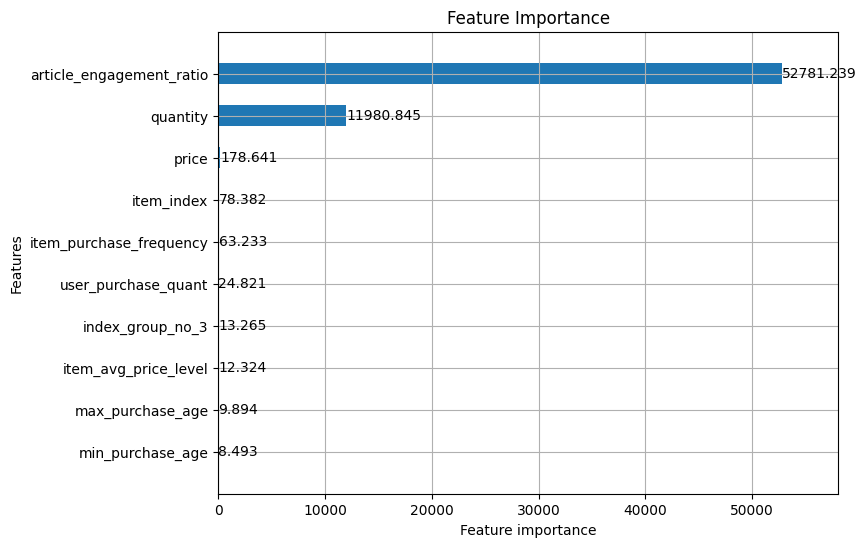

In [33]:
# Plot feature importance scores
fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_importance(ranker, max_num_features=10, height=0.5, ax=ax)
plt.title('Feature Importance')
plt.show()

Once the model is trained, it can be used to predict the probability of purchase for new user-product pairs, which can be used to generate recommendations for users.

After training the model, we can then get the probability that each user is likely to purchase an item from a candidate set of items. We can then sort these by descending probability to get the top 12 products as done below. <br>

A heuristic apparoach that we use to enhance LighGBM predictions here: <br>
1. Get a candidate set of top 500 most popular articles (by total purchase quanitity). <br>
2. Include the customer's predicitons to this set. <br>
3. Use lightGBM to predict the probability of purchases, and get the top 12. <br>

In [34]:
# dictionary 'user_products' that maps each user ID to a list of products they've purchased from the user-item matrix

user_products = {}
for user_idx in range(user_item_matrix.shape[0]):
    purchased_items = list(np.where(user_item_matrix[user_idx, :].toarray()[0] == 1)[0])
    user_products[user_idx] = purchased_items

In [35]:
# returns set of most pupular products in the catalog

def select_popular_products(df, n_products=500):
    # Group the dataframe by user and product and sum the quantity for each group
    product_quantities = df.groupby(['user_index', 'item_index'])['quantity'].sum()
    # Sort the products by quantity in descending order and select the top n_products
    popular_products = product_quantities.groupby('item_index').sum().sort_values(ascending=False).index.tolist()[:n_products]
    # return only the unique item_index values
    return list(set(popular_products))

In [36]:
# Generate candidate products for each user
# This can be done using a combination of popular products and user purchase history

popular_products = select_popular_products(final_df, 500)
print(len(popular_products))
# print first 10 popular products
print(popular_products[:20])

user_candidates = {}
for user_id in user_products:
    
    # Add user purchase history to candidate list
    user_history = user_products[user_id]
    popular_products_set = set(popular_products)
    user_history_set = set(user_history)
    candidate_products = list(popular_products_set - user_history_set)
    
    # Store candidate products (dataframes) for this user
    user_articles = final_df[final_df['item_index'].isin(candidate_products)]
    user_article_info = user_articles.groupby('item_index').first().reset_index()
    user_article_info = user_article_info.drop(['t_dat', 'target'], axis=1)
    user_candidates[user_id] = user_article_info

500
[0, 28674, 28675, 28676, 7, 6154, 18443, 14352, 14354, 45, 16432, 49, 16433, 16434, 18481, 22581, 16437, 8247, 53, 51]


In [37]:
# check where columns of X_test and user_candidates[0] dont match
for col in user_candidates[0].columns:
    if col not in X_test.columns:
        print(col)

In [38]:
for user_id in range(user_item_matrix.shape[0]):
    user_candidate_pool = user_candidates[user_id]
    item_probs = classifier.predict_proba(user_candidate_pool)
    top_items = user_candidate_pool.iloc[np.argsort(item_probs[:, 1])[::-1][:12]]
    print(f"Top recommended items for user {user_id}:")
    print(top_items['item_index'].values)

Top recommended items for user 0:
[14999 24178 21914   967  8582 21289 20131 18481  8528 22867 22611 19770]
Top recommended items for user 1:
[24178 21914 18481 20131 14999 21289   967 11552  6863 19770 22867 22611]
Top recommended items for user 2:
[21914 18481   967 14999 21289  8582 24178 20131 11552 22611 22867 19770]
Top recommended items for user 3:
[21289 18481 20131 21914   967 14999  8582 24178 11552  6863 19770 22867]
Top recommended items for user 4:
[  967 18481  8582 20131 24178 14999 21289 21914 11552 22611  6863  8528]
Top recommended items for user 5:
[18481   967 20131 24178 21289 21914  8582 14999 22867 19770  6863 22611]
Top recommended items for user 6:
[14999 21914   967 21289  8582 18481 20131 11552  8528 22867 19770  6863]
Top recommended items for user 7:
[21914   967 14999 18481 20131 21289 11552 22867 19770 22611  6863  8528]
Top recommended items for user 8:
[21289   967 18481 14999 20131 21914 24178  8582 11552  6863  8528 22867]
Top recommended items for us

In [40]:
preds = []
for user_id in range(user_item_matrix.shape[0]):
    user_candidate_pool = user_candidates[user_id]
    item_probs = ranker.predict(user_candidate_pool)
    top_items = user_candidate_pool.iloc[item_probs.argsort()[::-1][:12]]
    preds.append(top_items['item_index'].values)
    print(f"Top recommended items for user {user_id}:")
    print(top_items['item_index'].values)

Top recommended items for user 0:
[22715 12507 18481 18430 18405 24920 24995 18204 11062 18051 17907 11210]
Top recommended items for user 1:
[26080 26332 11552 17741 17740 19770 27257 27324 27333 27335  1438 17298]
Top recommended items for user 2:
[11645 25925 25972  4954 26079 26080 26332 26336 17154  1438 19770 22867]
Top recommended items for user 3:
[26332 18481 24920 24995 18430 18405 11210 25484 18051 17907 25766 25873]
Top recommended items for user 4:
[21292 22611 11552 25972 11645 26079 26080 26332 26336 17298 19770 17154]
Top recommended items for user 5:
[12507 20131 19770 17298  1438 27257  8582 17154 20082  4954  8544 26336]
Top recommended items for user 6:
[25972 25766 18430 18405 24920 11062 24995 18204 11210 18051 17907 25484]
Top recommended items for user 7:
[22867 11552 11062 18541 18481 18430 25484 18405 11210 25766 25873 18204]
Top recommended items for user 8:
[25972 25925  4954 26079 26080 26332 26336 17298 27257 27324 27333 17154]
Top recommended items for us